# Homework week 8 - Paolo Zinesi

### Outline:
1. Stability study of the excitatory-inhibitory two-neurons system at varying typical time $\tau_I$ (see calculations on the attached PDF file)
2. Simulation of trajectories for different regimes (by varying $\tau_I$)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## Simulation of trajectories for different regimes (by varying $\tau_I$)
The two-neurons system is described by the two differential equations
$$\begin{cases}
    \tau_E\, \dot{v}_E = - v_E + \psi\left( h_E + M_{EE}\, v_E + M_{EI}\, v_I \right),\\
    \tau_I\, \dot{v}_I = - v_I + \psi\left( h_I + M_{IE}\, v_E + M_{II}\, v_I \right),\\
  \end{cases}$$

where $v_E,v_I$ are, respectively, the post-synaptic firing rates of the excitatory and of the inhibitory neuron, $\psi(\cdot)$ is an activation function, $h_E,h_I$ are external stimuli and $M_{\alpha \beta}$ (with $\alpha,\beta = \{E,I\}$) are the interaction weights.

In this specific exercise we consider the choice of parameters
$$\begin{align}
M_{EE} = 1.25, \quad & M_{IE} = 1, & M_{EI} = -1, & \quad M_{II} = 0,\\
h_{E} = 10\, \text{Hz}, \quad&h_I = - h_E, &\tau_E = 10\, \text{ms}, &
\end{align}$$

and we use the nonlinear activation function
$$ \psi(x) = \max(0,x).$$

In [2]:
# interaction parameters
M_EE, M_IE, M_EI, M_II = 1.25, 1.0, -1.0, 0.0

# external stimuli (kHz)
h_E = 10.e-03
h_I = - h_E

# characteristic excitatory time (ms)
tau_E = 10.0

# nonlinear activation function
psi = lambda x: np.where(x>0, x, 0.0)

From the stability analysis we know that the only stationary point is $(v_E^*, v_I^*) = (\frac{8}{3} h_E, \frac{5}{3} h_E)$, and its behaviour changes according to the value of $\tau_I$. In particular, there are 3 critical values of $\tau_I$ for this particular set of parameters, which are:
* $\Delta_{-} = 2.87\, \text{ms}$
* $\tau_c = 40.0\, \text{ms}$
* $\Delta_{+} = 557\, \text{ms}$

The dynamics of the system is deeply influenced by the regime in which $\tau_I$ lies.

In [3]:
def dv_dt (t, v, tau_I):
    """
    v: vector of shape (2,N) containing N instances of [v_E, v_I]
    tau_I: characteristic time to simulate (in ms)

    return vector of shape (2,N) containing the derivatives [dv_E/dt, dv_I/dt]
    """

    v_E, v_I = v
    return np.array([-v_E/tau_E + psi(h_E + M_EE*v_E + M_EI*v_I)/tau_E,
                     -v_I/tau_I + psi(h_I + M_IE*v_E + M_II*v_I)/tau_I])

In [4]:
# stationary points
v_E_star, v_I_star = (8.0/3.0)*h_E, (5.0/3.0)*h_E

# meshgrid (near the fixed point)
L_E, L_I = 10, 10
Egrid_near = np.linspace(start=v_E_star-0.005*L_E, stop=v_E_star+0.005*L_E, num=200)
Igrid_near = np.linspace(start=v_I_star-0.005*L_I, stop=v_I_star+0.005*L_I, num=200)
vec_shape_near = (len(Igrid_near), len(Egrid_near))
Egrid_near, Igrid_near = np.meshgrid(Egrid_near, Igrid_near)

# meshgrid (far away from the fixed point)
Egrid_far = np.linspace(start=v_E_star-0.5*L_E, stop=v_E_star+0.5*L_E, num=200)
Igrid_far = np.linspace(start=v_I_star-0.5*L_I, stop=v_I_star+0.5*L_I, num=200)
vec_shape_far = (len(Igrid_far), len(Egrid_far))
Egrid_far, Igrid_far = np.meshgrid(Egrid_far, Igrid_far)

### Stable regime (2.87 ms $< \tau_I < $ 40 ms)

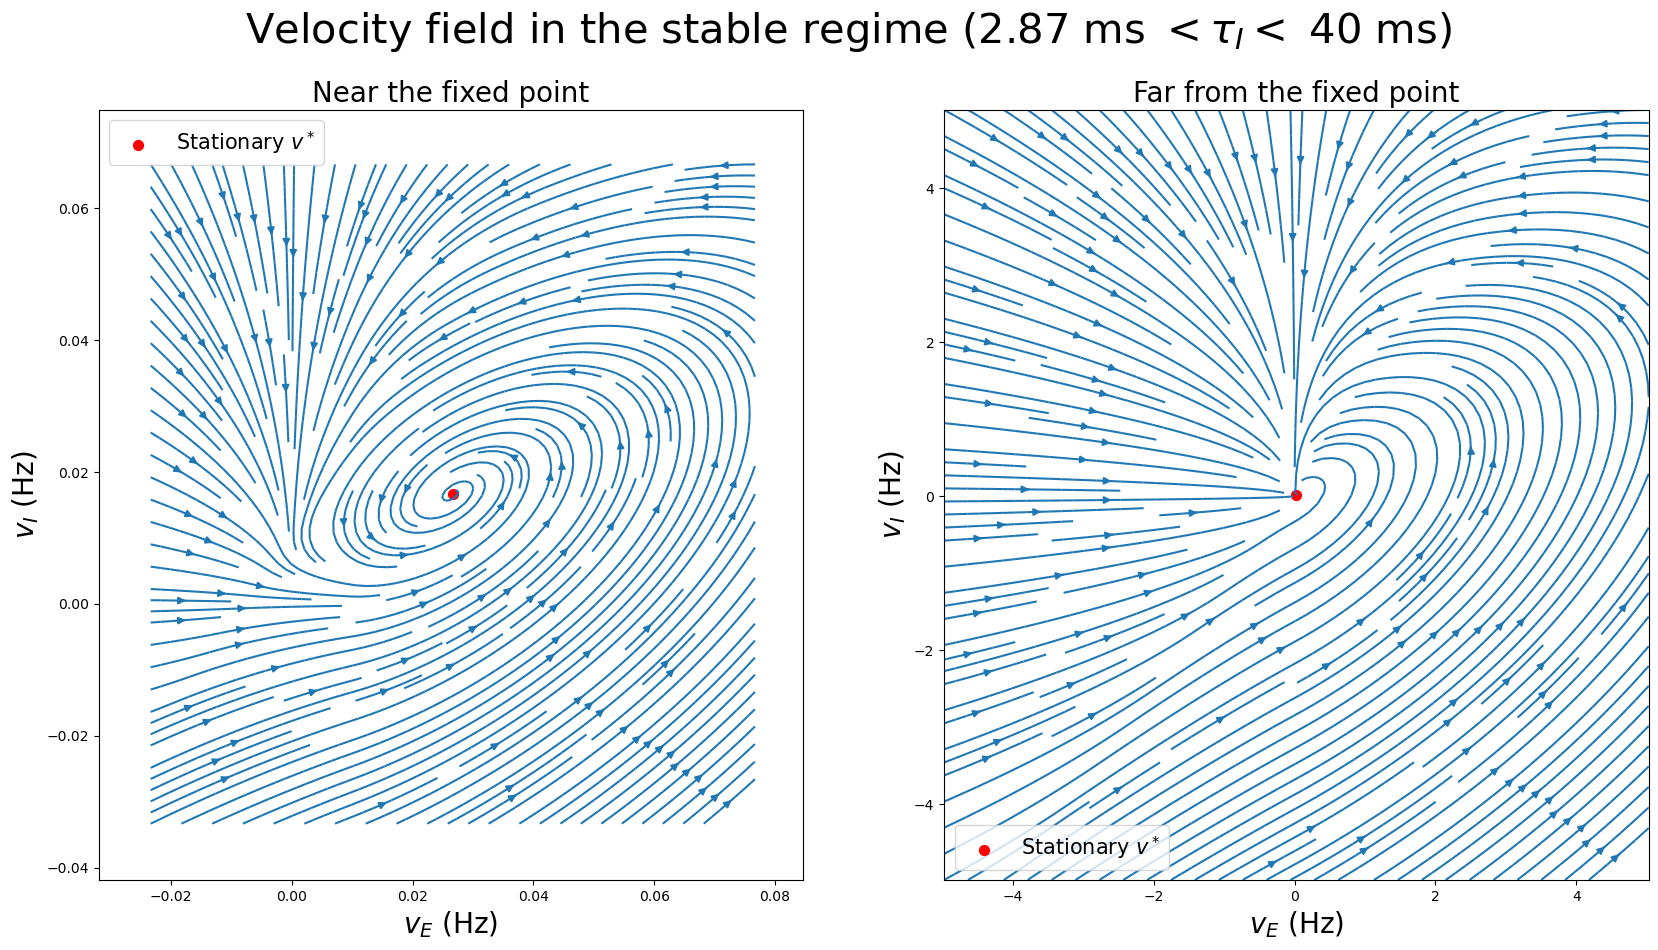

In [5]:
# compute derivative (stable) near the stationary point
tau_I = 20
dV_dt_field_near = dv_dt(0, np.concatenate((Egrid_near.reshape(1,-1),Igrid_near.reshape(1,-1))), tau_I=tau_I)
dV_dt_field_far = dv_dt(0, np.concatenate((Egrid_far.reshape(1,-1),Igrid_far.reshape(1,-1))), tau_I=tau_I)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
fig.suptitle(r"Velocity field in the stable regime (2.87 ms $< \tau_I < $ 40 ms)", fontsize=30)

# streamplot of derivative field (near)
axs[0].streamplot(x=Egrid_near, y=Igrid_near,
                  u=dV_dt_field_near[0,:].reshape(vec_shape_near), v=dV_dt_field_near[1,:].reshape(vec_shape_near),
                  density=2)
axs[0].set_title("Near the fixed point", fontsize=20)

# streamplot of derivative field (far)
axs[1].streamplot(x=Egrid_far, y=Igrid_far,
                  u=dV_dt_field_far[0,:].reshape(vec_shape_far), v=dV_dt_field_far[1,:].reshape(vec_shape_far),
                  density=2)
axs[1].set_title("Far from the fixed point", fontsize=20)

# common labels
for ax_ in axs:
    ax_.scatter(x=[v_E_star], y=[v_I_star], s=50, c="r", label=r"Stationary $v^*$")
    ax_.set_xlabel("$v_E$ (Hz)", fontsize=20)
    ax_.set_ylabel("$v_I$ (Hz)", fontsize=20)
    ax_.legend(fontsize=15)

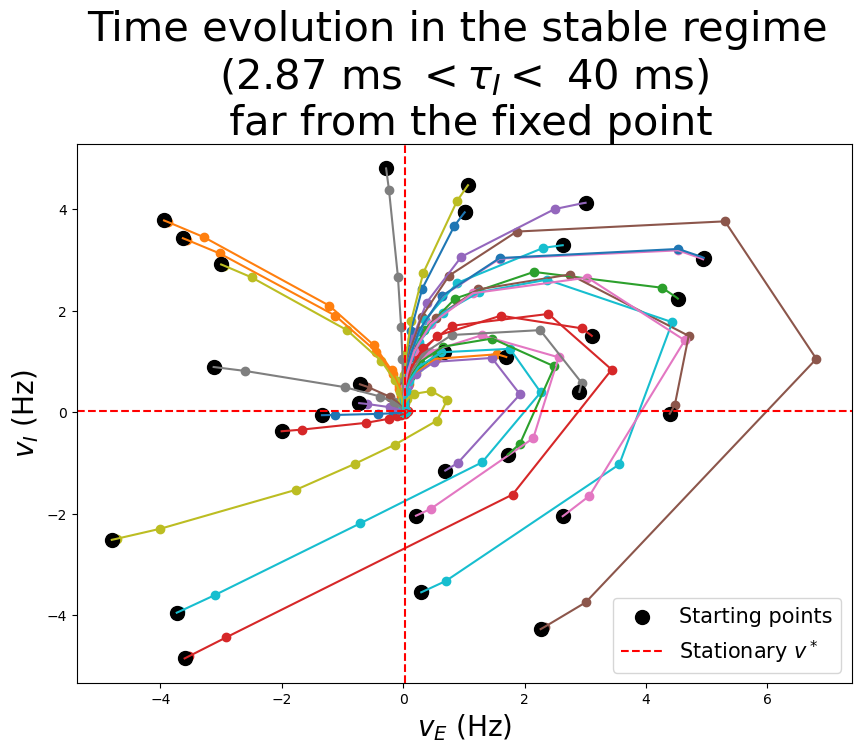

In [6]:
# random starting points
N_rand = 30
v0_rand = np.random.uniform(low=[v_E_star-0.5*L_E, v_I_star-0.5*L_I], high=[v_E_star+0.5*L_E, v_I_star+0.5*L_I], size=(N_rand, 2))

# simulate trajectories (ms)
t_max = 50*tau_E

# plots evolutions
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

# time evolution
for i in range(N_rand):
    res = solve_ivp(dv_dt, t_span=(0,t_max), y0=v0_rand[i,:], args=(tau_I,))

    ax.plot(res["y"][0,:], res["y"][1,:])
    ax.scatter(x=res["y"][0,1:], y=res["y"][1,1:])
    ax.scatter(x=v0_rand[i,0], y=v0_rand[i,1], s=100, c="k")


ax.scatter(x=v0_rand[0,0], y=v0_rand[0,1], s=100, label="Starting points", c="k")
ax.axhline(y=v_I_star, ls="--", c="r", label=r"Stationary $v^*$")
ax.axvline(x=v_E_star, ls="--", c="r")
ax.set_title("Time evolution in the stable regime \n"+r"(2.87 ms $< \tau_I < $ 40 ms)"+"\n far from the fixed point", fontsize=30)
ax.set_xlabel("$v_E$ (Hz)", fontsize=20)
ax.set_ylabel("$v_I$ (Hz)", fontsize=20)
ax.legend(fontsize=15)

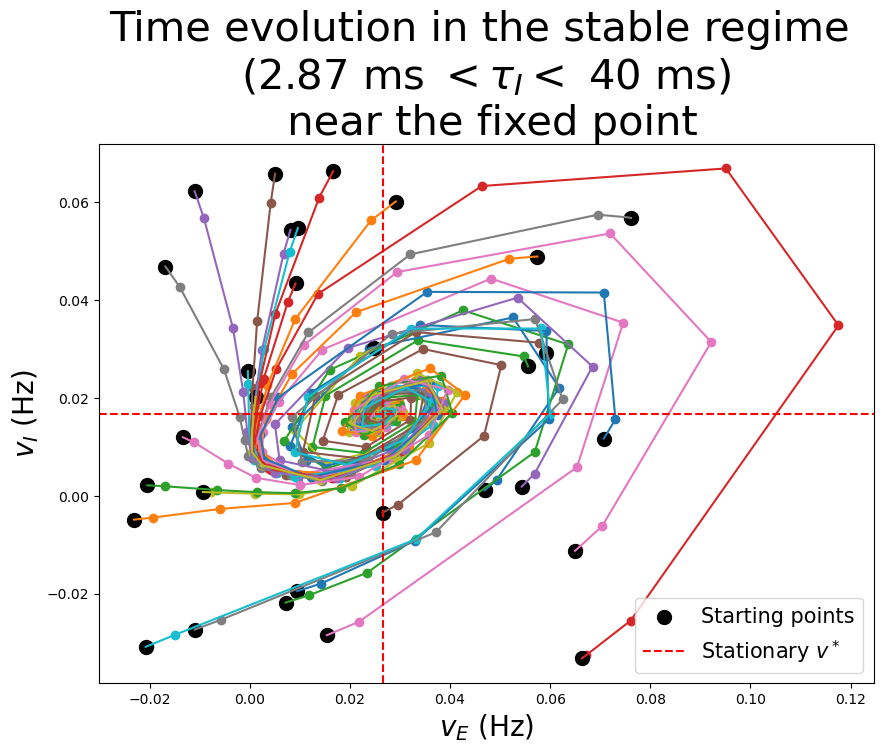

In [7]:
# random starting points
N_rand = 30
v0_rand = np.random.uniform(low=[v_E_star-0.005*L_E, v_I_star-0.005*L_I], high=[v_E_star+0.005*L_E, v_I_star+0.005*L_I], size=(N_rand, 2))

# simulate trajectories (ms)
t_max = 50*tau_E

# plots evolutions
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

# time evolution
for i in range(N_rand):
    res = solve_ivp(dv_dt, t_span=(0,t_max), y0=v0_rand[i,:], args=(tau_I,))

    ax.plot(res["y"][0,:], res["y"][1,:])
    ax.scatter(x=res["y"][0,1:], y=res["y"][1,1:])
    ax.scatter(x=v0_rand[i,0], y=v0_rand[i,1], s=100, c="k")


ax.scatter(x=v0_rand[0,0], y=v0_rand[0,1], s=100, label="Starting points", c="k")
ax.axhline(y=v_I_star, ls="--", c="r", label=r"Stationary $v^*$")
ax.axvline(x=v_E_star, ls="--", c="r")
ax.set_title("Time evolution in the stable regime \n"+r"(2.87 ms $< \tau_I < $ 40 ms)"+"\n near the fixed point", fontsize=30)
ax.set_xlabel("$v_E$ (Hz)", fontsize=20)
ax.set_ylabel("$v_I$ (Hz)", fontsize=20)
ax.legend(fontsize=15)

The simulation of trajectories in the stable regime (2.87 ms $< \tau_I < $ 40 ms) shows that the stationary point is an attractive equilibrium for every chosen starting point. The behaviours near the stationary point and far from it are similar and are compatible with the expected attractive behaviour predicted in the analytical stability analysis (which in principle is only valid near the fixed point). We can, thus, conclude that in the stable regime the nonlinearity of the activation function $\psi(x) = \max(0,x)$ does not change qualitatively the dynamical behaviour.

### Limit cycle regime (40 ms $< \tau_I < $ 557 ms)

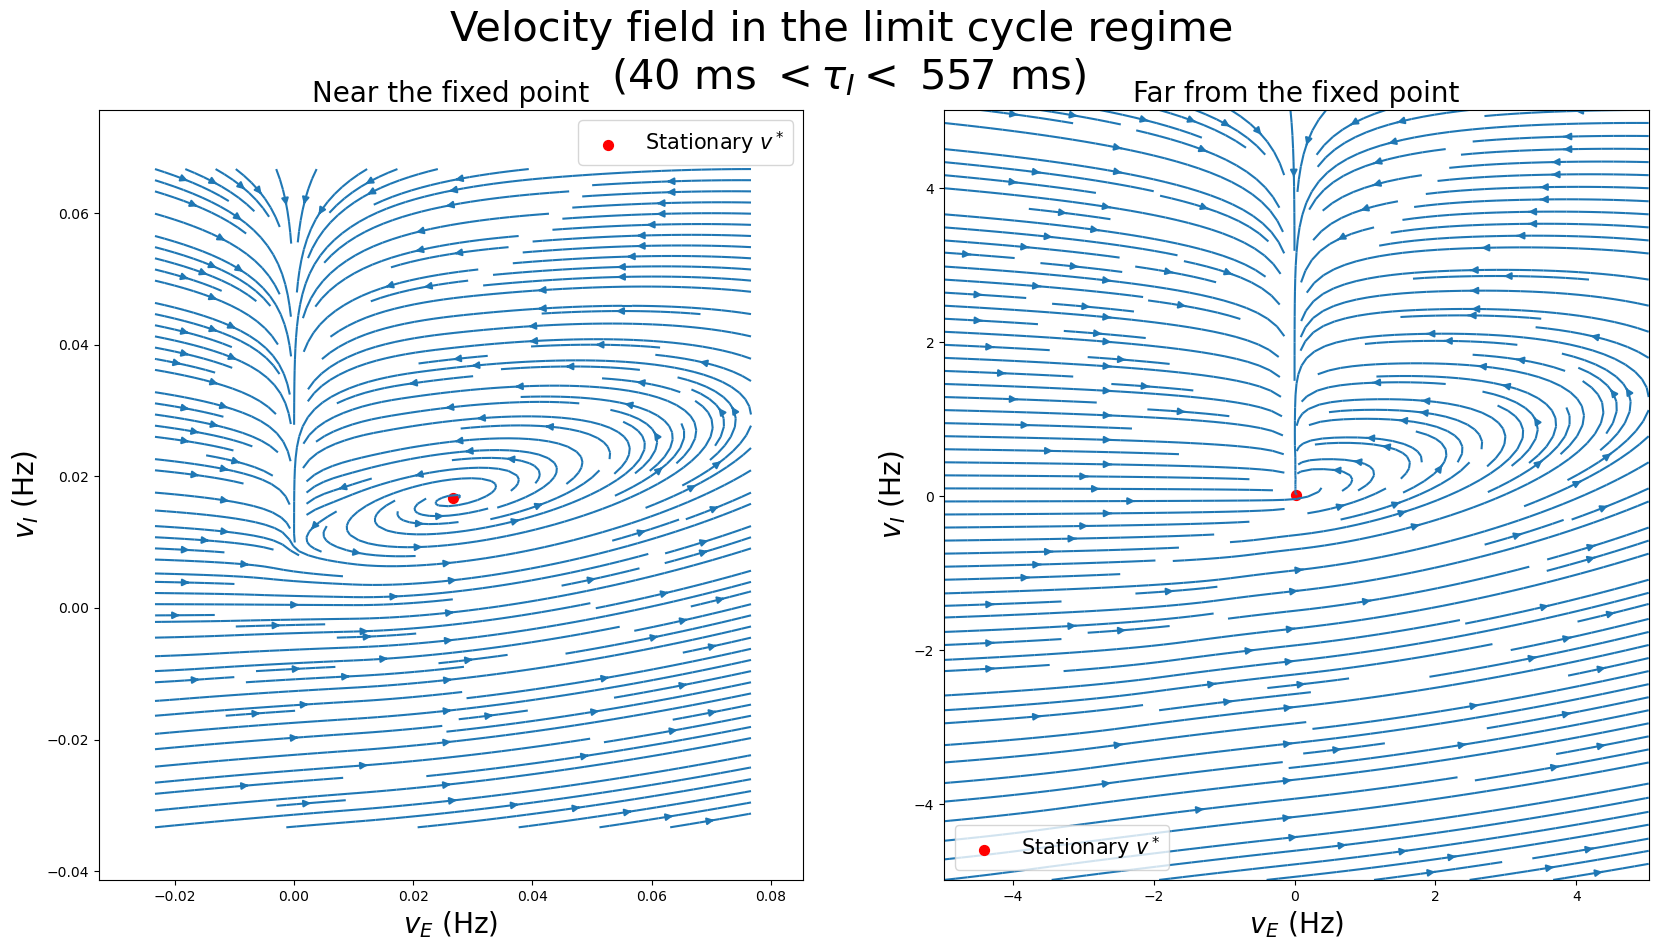

In [8]:
# compute derivative (stable) near the stationary point
tau_I = 100
dV_dt_field_near = dv_dt(0, np.concatenate((Egrid_near.reshape(1,-1),Igrid_near.reshape(1,-1))), tau_I=tau_I)
dV_dt_field_far = dv_dt(0, np.concatenate((Egrid_far.reshape(1,-1),Igrid_far.reshape(1,-1))), tau_I=tau_I)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
fig.suptitle("Velocity field in the limit cycle regime \n"+r"(40 ms $< \tau_I < $ 557 ms)", fontsize=30)

# streamplot of derivative field (near)
axs[0].streamplot(x=Egrid_near, y=Igrid_near,
                  u=dV_dt_field_near[0,:].reshape(vec_shape_near), v=dV_dt_field_near[1,:].reshape(vec_shape_near),
                  density=2)
axs[0].set_title("Near the fixed point", fontsize=20)

# streamplot of derivative field (far)
axs[1].streamplot(x=Egrid_far, y=Igrid_far,
                  u=dV_dt_field_far[0,:].reshape(vec_shape_far), v=dV_dt_field_far[1,:].reshape(vec_shape_far),
                  density=2)
axs[1].set_title("Far from the fixed point", fontsize=20)

# common labels
for ax_ in axs:
    ax_.scatter(x=[v_E_star], y=[v_I_star], s=50, c="r", label=r"Stationary $v^*$")
    ax_.set_xlabel("$v_E$ (Hz)", fontsize=20)
    ax_.set_ylabel("$v_I$ (Hz)", fontsize=20)
    ax_.legend(fontsize=15)

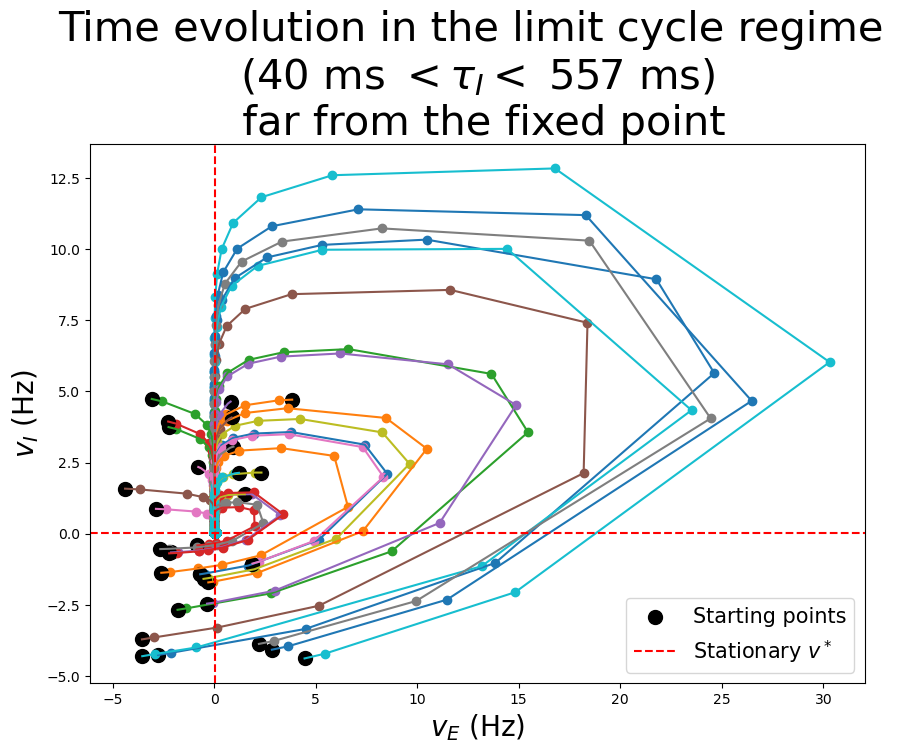

In [9]:
# random starting points
N_rand = 30
v0_rand = np.random.uniform(low=[v_E_star-0.5*L_E, v_I_star-0.5*L_I], high=[v_E_star+0.5*L_E, v_I_star+0.5*L_I], size=(N_rand, 2))

# simulate trajectories (ms)
t_max = 500*tau_E


# plots evolutions
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

# time evolution
for i in range(N_rand):
    res = solve_ivp(dv_dt, t_span=(0,t_max), y0=v0_rand[i,:], args=(tau_I,))

    ax.plot(res["y"][0,:], res["y"][1,:])
    ax.scatter(x=res["y"][0,1:], y=res["y"][1,1:])
    ax.scatter(x=v0_rand[i,0], y=v0_rand[i,1], s=100, c="k")


ax.scatter(x=v0_rand[0,0], y=v0_rand[0,1], s=100, label="Starting points", c="k")
ax.axhline(y=v_I_star, ls="--", c="r", label=r"Stationary $v^*$")
ax.axvline(x=v_E_star, ls="--", c="r")
ax.set_title("Time evolution in the limit cycle regime \n"+r"(40 ms $< \tau_I < $ 557 ms)"+"\n far from the fixed point", fontsize=30)
ax.set_xlabel("$v_E$ (Hz)", fontsize=20)
ax.set_ylabel("$v_I$ (Hz)", fontsize=20)
ax.legend(fontsize=15)

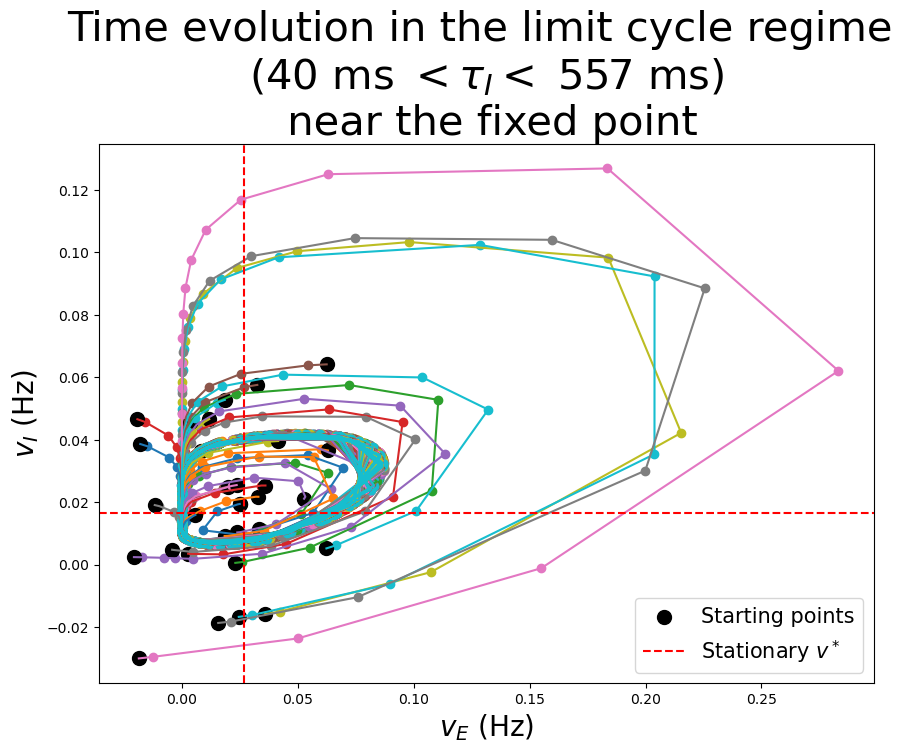

In [10]:
# random starting points
N_rand = 30
v0_rand = np.concatenate((np.random.uniform(low=[v_E_star-0.001*L_E, v_I_star-0.001*L_I], high=[v_E_star+0.001*L_E, v_I_star+0.001*L_I], size=(N_rand//5, 2)),
                          np.random.uniform(low=[v_E_star-0.005*L_E, v_I_star-0.005*L_I], high=[v_E_star+0.005*L_E, v_I_star+0.005*L_I], size=(N_rand-N_rand//5, 2))))

# simulate trajectories (ms)
t_max = 500*tau_E


# plots evolutions
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

# time evolution
for i in range(N_rand):
    res = solve_ivp(dv_dt, t_span=(0,t_max), y0=v0_rand[i,:], args=(tau_I,))

    ax.plot(res["y"][0,:], res["y"][1,:])
    ax.scatter(x=res["y"][0,1:], y=res["y"][1,1:])
    ax.scatter(x=v0_rand[i,0], y=v0_rand[i,1], s=100, c="k")


ax.scatter(x=v0_rand[0,0], y=v0_rand[0,1], s=100, label="Starting points", c="k")
ax.axhline(y=v_I_star, ls="--", c="r", label=r"Stationary $v^*$")
ax.axvline(x=v_E_star, ls="--", c="r")
ax.set_title("Time evolution in the limit cycle regime \n"+r"(40 ms $< \tau_I < $ 557 ms)"+"\n near the fixed point", fontsize=30)
ax.set_xlabel("$v_E$ (Hz)", fontsize=20)
ax.set_ylabel("$v_I$ (Hz)", fontsize=20)
ax.legend(fontsize=15)

In the limit cycle regime (40 ms $< \tau_I < $ 557 ms) the far away starting points are initially attracted towards the stationary point, even if locally the stationary point behaves as a repulsor. When attracted sufficiently near the fixed point, those points start feeling a repulsion due to the local behaviour of the stationary point. So, the local repulsive behaviour and the global attractive behaviour find a synthesis in a periodic oscillation around the stationary point. The shape drawn in the space ($v_E,v_I$) is approximately elliptical (that's why the name "limit cycle region") and the points in their time evolution tends to this ellipse, whenever they come from inside or outside it.
We can, thus, conclude that in the limit cycle regime the dynamical behaviour deviates significantly from the local behaviour near the equilibrium, because of the nonlinear activation function $\psi(x) = \max(0,x)$.